In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


from skimage.io import imread, imshow, show, imshow_collection
from skimage.transform import resize, rescale, rotate

warnings.filterwarnings('ignore')

# Load Data

In [2]:
data_train_1 = pickle.load(open("data/data_train_flatten_batch_1.pkl", "rb"))
data_train_2 = pickle.load(open("data/data_train_flatten_batch_2.pkl", "rb"))
labels_train_1 = pickle.load(open("data/labels_train_batch_1.pkl", "rb"))
labels_train_2 = pickle.load(open("data/labels_train_batch_2.pkl", "rb"))

In [3]:
data_train = np.concatenate((data_train_1, data_train_2))
labels_train = np.concatenate((labels_train_1, labels_train_2))

In [4]:
data_test = pickle.load(open("data/data_test_flatten.pkl", "rb"))
labels_test = pickle.load(open("data/labels_test.pkl", "rb"))

We don't need to shuffle data because are already splitted in train and test.

# Scale Data

In [5]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(data_train)
X_test_std = scaler.transform(data_test)

# PCA
We will use a 95% PCA

In [6]:
print("original number of features:", X_train_std.shape[1])
pca = PCA(0.95)
pca.fit(X_train_std)
print("Number of pricipal components:", pca.n_components_)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

original number of features: 3072
Number of pricipal components: 221


# Train Model

In [7]:
model = LogisticRegression().fit(X_train_pca, labels_train)

# Test Model

In [8]:
predictions = model.predict(X_test_pca)
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy score:", accuracy)

Accuracy score: 0.4059


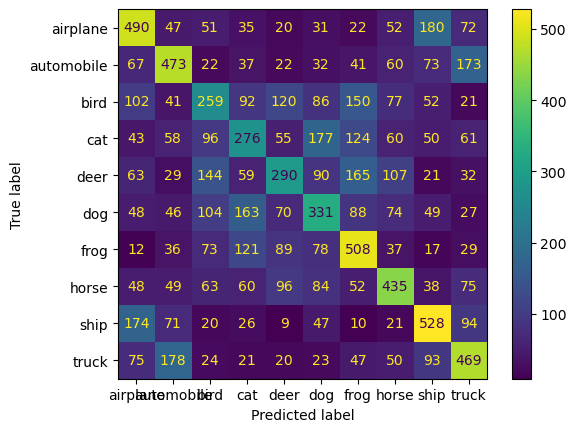

In [9]:
cm = confusion_matrix(labels_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Save Model

In [10]:
model_file_name = "logistic_regression_32x32_PCA.pkl"
pickle.dump(model, open(model_file_name, "wb"))

# Black And White

## Load data

In [11]:
train_batches = []
labels_batches = []

for i in [1, 2, 3, 4, 5]:
    data_filepath = "data/data_train_bw_flatten_batch_" + str(i) + ".pkl"
    labels_filepath = "data/labels_train_bw_batch_" + str(i) + ".pkl"
    train_batches.append(pickle.load(open(data_filepath, "rb")))
    labels_batches.append(pickle.load(open(labels_filepath, "rb")))
    
data_train_bw = np.concatenate(train_batches)
labels_train_bw = np.concatenate(labels_batches)

data_test_bw = pickle.load(open("data/data_test_bw_flatten.pkl", "rb"))
labels_test_bw = pickle.load(open("data/labels_test_bw.pkl", "rb"))

## Scale data

In [12]:
scaler = StandardScaler()

X_train_std_bw = scaler.fit_transform(data_train_bw)
X_test_std_bw = scaler.transform(data_test_bw)

## PCA
We will use a 95% PCA

In [13]:
del pca
print("original number of features:", X_train_std_bw.shape[1])
pca = PCA(0.95)
pca.fit(X_train_std_bw)
print("Number of pricipal components:", pca.n_components_)

X_train_bw_pca = pca.transform(X_train_std_bw)
X_test_bw_pca = pca.transform(X_test_std_bw)

original number of features: 1024
Number of pricipal components: 163


## Train model

In [14]:
model_bw = LogisticRegression().fit(X_train_bw_pca, labels_train_bw)

## Test model

In [15]:
predictions_bw = model_bw.predict(X_test_bw_pca)
accuracy_bw = accuracy_score(labels_test_bw, predictions_bw)
print("Accuracy score:", accuracy_bw)

Accuracy score: 0.3053


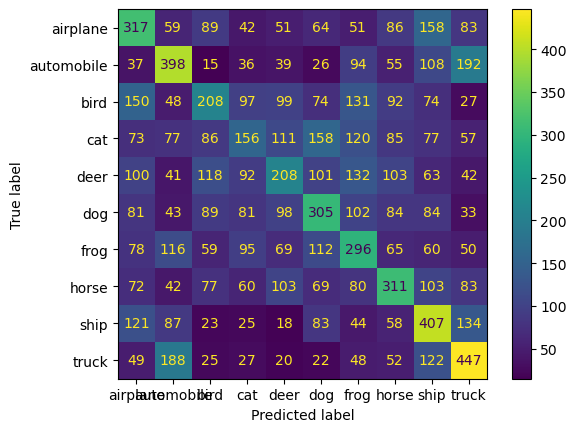

In [16]:
cm = confusion_matrix(labels_test_bw, predictions_bw, labels=model_bw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_bw.classes_)
disp.plot()

## Save model

In [17]:
model_file_name_bw = "logistic_regression_32x32_bw_PCA.pkl"
pickle.dump(model_bw, open(model_file_name_bw, "wb"))